# __ASE introduction__
The aim of this notebook is to provide a solid introduction to ASE, as a standalone programme and as an interface to several NNPs such as ANI, MACE, Orbital, SchNet. 

### __References__
ASE includes extensive [documentation](https://wiki.fysik.dtu.dk/ase/) where installatin procedure and tutorials can be found. 

Introductory tutorials can be found [here (getting started)](https://wiki.fysik.dtu.dk/ase/gettingstarted/gettingstarted.html), with a follow-up set of tutorials [here (tutorials)](https://wiki.fysik.dtu.dk/ase/tutorials/tutorials.html). 

- Additional ASE tutorials used in this introduction:
    - Complete ASE introduction [tutorial](https://docs.matlantis.com/atomistic-simulation-tutorial/en/index.html). 
    - Official ASE MD [tutorials](https://wiki.fysik.dtu.dk/ase/tutorials/md/md.html). 

- MD tutorials.
    - Short introduction with MACE FF. [link](https://rwexler.github.io/comp-prob-solv/lecture-23-ase.html). 
    - Official MD [documentation](https://wiki.fysik.dtu.dk/ase/ase/md.html). 
    - Extra MD [tutorial](https://docs.matlantis.com/atomistic-simulation-tutorial/en/1_5_ase_calculator.html). 


### __ASE Installation__
To start, as goes for many different software, but particularly for ASE and external calculators, separate conda environments are recommended. The installation is as follows:
- Installation process
    - Create new conda environment (python 3.10 is standard). Check the Python requirement for the external calculator wanted. Usually  `python>3.9`.  
    - `conda install ase` (installs `scipy` and `numpy` dependencies) and `conda install matplotlib`. 
    - Check the environment works installing `conda install pytest` and `ase test`.
    - For ASE representations inside Jupyter Notebook, conda install `notebook`, `ipywidgets` and `nglview`. 

Detailed installation guide [here](https://wiki.fysik.dtu.dk/ase/install.html#download-and-install). 

**Installation of ASAP3-EMP calculator.** Install `openmpi` and `libxc`. Then do `pip install asap3`. Note that the conda installation via `conda-forge` does not work idk why... Read [the docs](https://asap3.readthedocs.io/en/latest/installation/Installing_ASE_Asap_and_GPAW_on_a_Mac.html#installing-ase-asap-and-gpaw-on-a-mac). 


**Installation of GPAW DFT calculator.** Install `openmpi` and `libxc`. Then do `pip install asap3`. Finally, `pip install gpaw`. Check the [installation guide](https://gpaw.readthedocs.io/install.html#install-paw-datasets) on how to install the dataset. 

**Comment.** This introduction only uses basic ASE calculators. Separate introductions can be found in each of the NNP models directory. 

# __1. ASE program structure__

Computing the adsoption energy of a N2 molecule in a Copper slab. 

In [1]:
from ase import Atoms
from ase import units
from ase.build import add_adsorbate, fcc111

from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.optimize import QuasiNewton
from ase.md.verlet import VelocityVerlet


# define N2 position parameters
h = 1.85
d = 1.10

# define the Atoms view
slab = fcc111('Cu', size=(4, 4, 2), vacuum=10.0)
molecule = Atoms('2N', positions=[(0., 0., 0.), (0., 0., d)])

# define the calculator to be used
slab.calc = EMT()
molecule.calc = EMT()

# compute the separate energies 
e_slab = slab.get_potential_energy()
e_N2 = molecule.get_potential_energy()

# add the two molecules together (defines new surface)
add_adsorbate(slab, molecule, h, 'ontop')

# ad optimization restricton
constraint = FixAtoms(mask=[a.symbol != 'N' for a in slab])
slab.set_constraint(constraint)

# optimize the system
dyn = QuasiNewton(slab, trajectory='N2Cu.traj')
dyn.run(fmax=0.05)

print('Adsorption energy:', e_slab + e_N2 - slab.get_potential_energy())

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 17:36:22       11.689927       1.0797
BFGSLineSearch:    1[  2] 17:36:22       11.670814       0.4090
BFGSLineSearch:    2[  4] 17:36:22       11.625880       0.0409
Adsorption energy: 0.32351942231763964


Once optimized, run an NVE simulation

In [2]:
# define the dynamics (integrator, timestep)
dyn = VelocityVerlet(molecule, timestep=1.0 * units.fs)

# do 200 steps, and record each 20 steps
for i in range(10):
    pot = molecule.get_potential_energy()
    kin = molecule.get_kinetic_energy()
    print('%2d: %.5f eV, %.5f eV, %.5f eV' % (i, pot + kin, pot, kin))
    dyn.run(steps=20)

 0: 0.44034 eV, 0.44034 eV, 0.00000 eV
 1: 0.43816 eV, 0.26289 eV, 0.17527 eV
 2: 0.44058 eV, 0.43142 eV, 0.00916 eV
 3: 0.43874 eV, 0.29292 eV, 0.14582 eV
 4: 0.44015 eV, 0.41839 eV, 0.02176 eV
 5: 0.43831 eV, 0.28902 eV, 0.14929 eV
 6: 0.43947 eV, 0.36902 eV, 0.07045 eV
 7: 0.43951 eV, 0.35507 eV, 0.08444 eV
 8: 0.43959 eV, 0.36221 eV, 0.07738 eV
 9: 0.43933 eV, 0.36044 eV, 0.07889 eV


Note that ASE has eV as energy unit and Å as length unit (and fs? as time unit?)

In [3]:
# output to an external file format (not .traj ASE format)
from ase.io import write
write('slab.xyz', slab)

# read from the file
from ase.io import read
slab_from_file = read('slab.xyz')

# read a specific configuration from the .traj file (default the last one)
last_snapshot = read('N2Cu.traj', -1)
print(last_snapshot)

Atoms(symbols='Cu32N2', pbc=[True, True, False], cell=[[10.210621920333747, 0.0, 0.0], [5.105310960166873, 8.842657971447272, 0.0], [0.0, 0.0, 22.08423447177455]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), calculator=SinglePointCalculator(...))


/Users/sergiortizropero/miniconda3/envs/ASE_extra/lib/python3.10/site-packages/ase/io/extxyz.py:311: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


Viewing options https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html. 

In [4]:
# GUI visualization of the ASE objects
from ase.visualize import view

# basic jupyter visualization
#view(slab, viewer='x3d')

# basic (but more advanced) visualization
#view(slab, viewer='ngl')

# customization of the view
v = view(slab, viewer='ngl')

# nglviewer options
v.custom_colors({'N':'green','Cu':'blue'})
v.view._remote_call("setSize", target="Widget", args=["600px", "400px"])
v.view.center()
v.view.background='black'
v.view.parameters=dict(clipDist=-200)

v

As we have seen, the general procedure in ASE is the following 

- General procedure
    - Define the atoms view, that is, the structure of the system. 
    - Add a calculator to the structure. This allows us to check what can 'asked' about the system. 
    - Perform optimizations
    - Perform MD of the system
    - Read trajectory files. 

### __N2 interatomic potential DFT calculation__
In this tutorial the H2 PES is obtained as a function of interatomic distance. The data is written in a trajectory file. 

In [5]:
# calculator
from gpaw import GPAW

# general imports
from ase import Atoms
from ase.io import Trajectory
from ase.io import write
from ase.io import iread
from ase.visualize import view


# define the structure
atoms = Atoms('N2', positions=[[0, 0, -1], [1, 0, 1]])
atoms.center(vacuum=3.0)
print(atoms.positions)

# save the initial position
write('N2_initial_pos.xyz', atoms)

# # inspect it (rotate holding right click)
# ! ase gui myatoms.traj
#view(atoms, viewer='ase')
view(atoms, viewer='x3d')


# define the calculation and assign it to the molecule
calc = GPAW(mode='lcao', basis='dzp', txt='gpaw.txt', xc='LDA')
atoms.calc = calc

# save the energy and force data of the point calculations (no relaxation)
traj = Trajectory('binding_curve.traj', 'w')

# define the structures (0.5, 3.5) Å
step = 0.05
nsteps = int(3 / step)

for i in range(nsteps):
    # define the new structure
    d = 0.5 + i * step
    atoms.positions[1, 2] = atoms.positions[0, 2] + d
    atoms.center(vacuum=3.0)

    # compute
    e = atoms.get_potential_energy()
    f = atoms.get_forces()
    print('distance, energy', d, e)
    print('force', f)

    # save it to the trajectory
    traj.write(atoms)


# read the results from the trajectory file 
import matplotlib.pyplot as plt

energies = []
distances = []
for atoms in iread('binding_curve.traj'):
    energies.append(atoms.get_potential_energy())
    distances.append(atoms.positions[1, 2] - atoms.positions[0, 2])

ax = plt.gca()
ax.plot(distances, energies)
ax.set_xlabel('Distance [Å]')
ax.set_ylabel('Total energy [eV]')
plt.show()

[Sergis-MacBook-Pro.local:14978] shmem: mmap: an error occurred while determining whether or not /var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T//ompi.Sergis-MacBook-Pro.501/jf.0/2263220224/sm_segment.Sergis-MacBook-Pro.501.86e60000.0 could be created.


[[3. 3. 3.]
 [4. 3. 5.]]


FileNotFoundError: Could not find required basis set file "N.dzp.basis".

You need to set the GPAW_SETUP_PATH environment variable to point to
the directories where PAW dataset and basis files are stored.  See
https://gpaw.readthedocs.io/install.html#install-paw-datasets
for details.


### __External calculator setup__

In this section, how ASE interfaces with external calculators is described and an example calculator VASP is installed. The venv used is `ASE_extra`. 

**Note.** Check the list of [supported calculators](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html#supported-calculators). 

- **Usage of external calculators.** 
    - The external package (that contains the calculator) must be located and defined with an environment variable (executable location, which ASE will call). 
    - ASE handles writing the input files, which are required for the run, and then executes the `EXTERNAL_PROGRAM_EXECUTABLE` (previously defined enviornment variable), i.e. executes the external software (e.g. ORCA). Once the ORCA run is complete, ASE then reads all of the relevant files, and stores properties in the calculator object.
    
    - **FHI-aims example.** Different calculators communicate with computational codes in different ways. GPAW is written in Python, so ASE and GPAW run within the same process. However FHI-aims is a separate program. What the Aims calculator does for us is to generate an input file, run FHI-aims, read the output, and return the results. 
    - Many ASE calculators support more advanced ways of communicating. These calculators can communicate with persistent external processes over pipes (Lammpsrun, CP2K) or sockets (Siesta, Aims, Espresso), or they can work within the same process through direct library calls (Lammpslib, GPAW).

**Note.** In this case, I did not install any of the software due to time constraints. The general procedure on how to interface ASE with an external program might vary, but the general procedure is as follows (example is ). 

**VASP** The first step, is to tell ASE how to execute VASP, and where to find the pseudopotentials via two environment variables. `ASE_VASP_COMMAND` is the default way to execture VASP (points to the executable `vasp_std`). The second environment variable is `VASP_PP_PATH`, the path to the VASP pseudopotentials. 

```bash
$ export ASE_VASP_COMMAND="mpiexec $HOME/vasp/bin/vasp_std"
$ export VASP_PP_PATH=$HOME/vasp/mypps
```

**FHI-aims.** ASE can communicate with FHI-aims over sockets using the i-PI protocol (http://ipi-code.org/). This is done by wrapping the calculator in a `ase.calculators.socketio.SocketIOCalculator`. The socket calculator will use the calculator it wraps to launch a calculation, then run it. The documentation on the socket I/O calculator already provides full examples, so we only need minor adjustments to run them on our local machine. Check the last section of this [tutorial](https://wiki.fysik.dtu.dk/ase/gettingstarted/tut02_h2o_structure/h2o.html) for more info on how to install FHI-aims. 

```bash
$ export ASE_AIMS_COMMAND=aims.x
$ export AIMS_SPECIES_DIR=/home/alumne/software/FHIaims/species_defaults/light
```

**Note.** The env variables will be 'forgotten' once the shell (conda environment) is restarted. We can define these env variables in the `.bash_profile` (macOS) or call them inside the ASE python script executing the command with `!<command>`. 

#### __Check the external calculator is well defined__
Once the environment variables are defined, ASE should 'see' them. Run 
```console
ase info --calculators
```
to check that it is properly configured. If we want to check if GROMACS calculator is correctly defined, use `ase info --calculators | grep gaussian` to quickly check it. 

An aditional quick test on the N2 molecule can be performed when dealing with QM (electronic structure) or NNP potentials:

In [6]:
from ase.build import molecule
from ase.calculators.vasp import Vasp

# define the molecule
atoms = molecule('N2')
atoms.center(vacuum=5)

# define the calculator and use it
calc = Vasp(xc='pbe',  # Select exchange-correlation functional
            encut=400, # Plane-wave cutoff
            kpts=(1, 1, 1)) # k-points
atoms.calc = calc

# compute the energy
print(f'Potential energy: {atoms.get_potential_energy():.2f} eV')

CalculatorSetupError: Vasp cannot handle non-periodic boundaries. Please enable all PBC, e.g. atoms.pbc=True

### __H2O structure optimization__
The several optimization algorithms included in ASE operate on top of `Atoms`. Usually, big systems with different 'groups' of atoms (i.e. a protein in a solvent) require a minimization that involves first optimizing the solvent and then the side chains and finally a free optimization. 

The procedure is similar to performing an MD, a trajectory file will be generated with energy and forces of each step. 

In [7]:
from gpaw import GPAW

from ase import Atoms
from ase.constraints import FixAtoms
from ase.optimize import BFGS
from ase.io import Trajectory, read
from ase.visualize import view

# define a water molecule in the void
atoms = Atoms('HOH', positions=[[0, 0, -1], [0, 1, 0], [0, 0, 1]])
atoms.center(vacuum=3.0)

# define the calculator and apply it
calc = GPAW(mode='lcao', basis='dzp', txt='gpaw.txt')
atoms.calc = calc

# (optional)
# optimization restrictions (fix O atom)
# constraint = FixAtoms(mask=[a.symbol != 'O' for a in atoms])

# define the optimizer and maximum force until convergence 
opt = BFGS(atoms, trajectory='opt.traj', logfile='opt.log')
opt.run(fmax=0.05)

# trajectory visualization
traj = Trajectory('opt.traj')
view(traj, viewer='ngl')

FileNotFoundError: Could not find required basis set file "H.dzp.basis".

You need to set the GPAW_SETUP_PATH environment variable to point to
the directories where PAW dataset and basis files are stored.  See
https://gpaw.readthedocs.io/install.html#install-paw-datasets
for details.


Once the optimization has ended, we can analyze the energy of each configuration and structrual parameters (O-H distance and HOH angle). 

In [8]:
# TODO. Compute the distances
# TODO. Compute the angles

The same optimization can be performed using other calculators.  

In [ ]:
# FHI-aims calculator
import os
from ase.calculators.aims import Aims

os.environ['ASE_AIMS_COMMAND'] = 'aims.x'
os.environ['AIMS_SPECIES_DIR'] = '/home/myname/FHIaims/species_defaults/light'

calc = Aims(xc='LDA', compute_forces=True)

In [ ]:
# FHI-aims/socket-io calculator
import os
from ase.calculators.aims import Aims
from ase.calculators.socketio import SocketIOCalculator

os.environ['ASE_AIMS_COMMAND'] = 'aims.x'
os.environ['AIMS_SPECIES_DIR'] = '/home/myname/FHIaims/species_defaults/light'

aims_calc = Aims(xc='LDA',
            compute_forces=True,
            use_pimd_wrapper=('UNIX:mysocket', 31415))

# ... define the atoms and optimization

with SocketIOCalculator(aims_calc, unixsocket='mysocket') as calc:
    atoms.calc = calc
    opt.run(fmax=0.05)

### __H2O NMO Analysis__
Once the optimization has concluded, we are in the position of computing the Hessian and performing an NMO analysis. This tutorial uses GPAW DFT. 

In [9]:
from math import cos, pi, sin

from ase import Atoms
from ase.build import molecule
from ase.optimize import QuasiNewton
from ase.vibrations import Vibrations
from gpaw import GPAW

# define a water molecule
# H2O = molecule("H2O")
d = 0.9575
t = pi / 180 * 104.51
H2O = Atoms('H2O', positions=[(0, 0, 0), (d, 0, 0), (d*cos(t), d*sin(t), 0)])
H2O.center(vacuum=3.5)

# define the calculator 
H2O.calc = GPAW(txt='h2o.txt', mode='lcao', basis='dzp', symmetry='off')

# optimizer
opt = QuasiNewton(H2O, trajectory='opt.traj', logfile='opt.log')
opt.run(fmax=0.05)

# create vibration calculator
vib = Vibrations(H2O, indices=None, delta=0.01, name="vib-h2o", nfree=2)
vib.clean()

# compute and diagonalize the Hessian
vib.run()

# output the square root of the eigenvalues $\omega^2$. 
vib.summary(method='frederiksen')

# Make trajectory files to visualize normal modes: 9 total, 3 vibrations
for mode in range(9):
    vib.write_mode(mode)
    traj = Trajectory(f"vib-h2o.{mode}.traj")

view(traj, viewer='x3d')

FileNotFoundError: Could not find required basis set file "H.dzp.basis".

You need to set the GPAW_SETUP_PATH environment variable to point to
the directories where PAW dataset and basis files are stored.  See
https://gpaw.readthedocs.io/install.html#install-paw-datasets
for details.


The summary displays $3N$ normal modes, with $6$ of these corresponding to imaginary frequencies (rotation and translation), and the other $3N-6$ the vibrational normal modes, with the frequency (and corresponding energy spacing $h\nu_\mu$). The same procedure can be done for CO2. 

In [ ]:
# define a CO2 molecule
atoms = molecule('CO2')

# define the calculator 
atoms.calc = GPAW(txt='CO2.txt', mode='lcao', basis='dzp', symmetry='off')

# optimizer
opt = QuasiNewton(atoms, trajectory='opt_CO2.traj', logfile='opt_CO2.log')
opt.run(fmax=0.05)

# create vibration calculator
vib = Vibrations(atoms, indices=None, delta=0.01, name="vib-CO2", nfree=2)
vib.clean()

# compute and diagonalize the Hessian
vib.run()

# output the square root of the eigenvalues $\omega^2$. 
vib.summary(method='frederiksen')
vib.write_mode(mode)

# visualize the vibration
mode = 5
traj = Trajectory(f"vib-CO2.{mode}.traj")
view(traj, viewer='x3d')

### __Atoms and manipulation__
Before performing an MD, or point-wise electronic structure calculation, it is important to correctly define the atomic structure to simulate. 
- `Atoms` is a class containing the view (atomic positions, structure of a system). It contains the element type, coordinates, velocities, PBC bool and cell info. Methods include get_masses, len_atoms, get_momenta, etc. if applicable. 
- **Units.** ASE uses eV for energy, Å for length and e for charge. 
- **Molecular databases.** A number of molecules are predefined in ASE. E.g. `ase.collections g2` contains 'usual' molecules

**Tips.** Info about an ASE class can be retreived via `Atoms?` in an interactive ipy environment. 


In [10]:
from ase.build import molecule
from ase.collections import g2

print(f"Available molecule:", len(g2.names), g2.names)

Available molecule: 162 ['PH3', 'P2', 'CH3CHO', 'H2COH', 'CS', 'OCHCHO', 'C3H9C', 'CH3COF', 'CH3CH2OCH3', 'HCOOH', 'HCCl3', 'HOCl', 'H2', 'SH2', 'C2H2', 'C4H4NH', 'CH3SCH3', 'SiH2_s3B1d', 'CH3SH', 'CH3CO', 'CO', 'ClF3', 'SiH4', 'C2H6CHOH', 'CH2NHCH2', 'isobutene', 'HCO', 'bicyclobutane', 'LiF', 'Si', 'C2H6', 'CN', 'ClNO', 'S', 'SiF4', 'H3CNH2', 'methylenecyclopropane', 'CH3CH2OH', 'F', 'NaCl', 'CH3Cl', 'CH3SiH3', 'AlF3', 'C2H3', 'ClF', 'PF3', 'PH2', 'CH3CN', 'cyclobutene', 'CH3ONO', 'SiH3', 'C3H6_D3h', 'CO2', 'NO', 'trans-butane', 'H2CCHCl', 'LiH', 'NH2', 'CH', 'CH2OCH2', 'C6H6', 'CH3CONH2', 'cyclobutane', 'H2CCHCN', 'butadiene', 'C', 'H2CO', 'CH3COOH', 'HCF3', 'CH3S', 'CS2', 'SiH2_s1A1d', 'C4H4S', 'N2H4', 'OH', 'CH3OCH3', 'C5H5N', 'H2O', 'HCl', 'CH2_s1A1d', 'CH3CH2SH', 'CH3NO2', 'Cl', 'Be', 'BCl3', 'C4H4O', 'Al', 'CH3O', 'CH3OH', 'C3H7Cl', 'isobutane', 'Na', 'CCl4', 'CH3CH2O', 'H2CCHF', 'C3H7', 'CH3', 'O3', 'P', 'C2H4', 'NCCN', 'S2', 'AlCl3', 'SiCl4', 'SiO', 'C3H4_D2d', 'H', 'COF2', '

- `bulk` method is used to create crystal structures via specifying the values that characterize the crystal: name, crystalstructure, a, b, c, alpha, covera, cubic kwargs. Note that `bulk` method uses PBCs to define the crystal (the representation will show so). 
- To define the real cell (for example, multiple atoms in one direction), use the `repeat` method or by multiplication


In [11]:
from ase.build import bulk

fe_sc_atoms = bulk(name="Fe", crystalstructure="sc", a=2.0)
fe_sc_atoms

fe222_atoms = fe_sc_atoms.repeat((2, 3, 4))
#fe222_atoms = fe_sc_atoms * (2, 3, 4)

fe222_atoms

Atoms(symbols='Fe24', pbc=True, cell=[4.0, 6.0, 8.0])

[El tutorial continua però això em dona bastant igual.]

- `read` and `write` functions allow outputs and inputs of ASE objects. 
- External molecules can be importes in ASE through the smile or via an external molecular structural database. 

The structure can be modified via translation and rotation (and or combination of them) using `Atoms.translate([x, y, z])` to the `Atoms` view. Rotations can be specified using the normal plane via `Atoms.rotate(angle, v='z')`, additional option of `rotate_cell=True` should be used to rotate the PBC crystalline cell. 

In [12]:
from ase.visualize import view
atoms = bulk("Fe") * (2, 3, 4)

atoms.rotate(90, v=[0, 0, 1], rotate_cell=True)
view(atoms, viewer='ngl')

Additional geometry moves include `rattle` (creates a messy structure by randomly moving each atom). Kwargs include `stdev` and `seed` for degree of movement and pseudorandom generator. 

In [13]:
import numpy as np
atoms = bulk("Si") * (2, 3, 4)
atoms2 = atoms.copy()

atoms.rattle(stdev=0.2, rng=np.random.RandomState())
atoms2.rattle(stdev=0.2, rng=np.random.RandomState())

print("atoms & atoms2 positions are same? --> ", np.allclose(atoms.positions, atoms2.positions))
view(atoms, viewer='ngl')

atoms & atoms2 positions are same? -->  False


Additionally, if an atom has moved outside of the cell, it can be brought back to the cell (PBC) using `wrap`

In [14]:
atoms.wrap()
view(atoms, viewer='ngl', )

Additional `Atoms` transformation (regarding solid or periodic structures) can be found [here](https://docs.matlantis.com/atomistic-simulation-tutorial/en/1_7_ase_playground2.html). 

### __Generic ASE procedure__
The atomic structure is represented by the `Atoms` class. Each physical property can be computed via a calculator applied to the structure/view (`Atoms` class). The calculator is 'added' by defining `Atoms.calc` attribute. The calculator contains previous calculation results and previous input. 

Once the calculator has been added, the physical properties can be extracted from the `Atoms` object calling e.g. `Atoms.get_potential_energy()`. Methods include `get_x_energy()`, `get_forces()`, `get_charges()`, `get_magnetic_moment`, `get_dipole_moment`, among others (specific to the calculator).  

The calculator class is in charge of calculating the associated physical properties. Note that these calculators might be based on QM, MM, or NNP methods. 

Note that the chache of the calculator can be reset using `calculator.reset()` on the `Atoms.calc` object. This is impractical for simulations that require several point-wise calculations. 

In [15]:
from ase.build import bulk
from ase.calculators.emt import EMT


calculator_emt = EMT()

atoms = bulk("Cu")
atoms.calc = calculator_emt

E_pot_emt = atoms.get_potential_energy()
print(f"Potential energy {E_pot_emt:.5f} eV")

Potential energy -0.00568 eV


## __Additional Examples__
These examples require a QM calculator to run and have been extracted from matlantis. 

### __Dissociation of a diatomic molecule__

In [16]:
# diatomic dissociation potential:
# https://docs.matlantis.com/atomistic-simulation-tutorial/en/1_8_diatomic_potential.html
# TODO

### __Structural relaxation (optimization)__ 
Optimization procedure requires a structural view (`Atoms`), a calculator to perform single-point calculations (using the interatomic potential of the given calculator) and then specifying the optimization algorithm to use. Relevant optimization algorithms are provided in the [documentation](https://wiki.fysik.dtu.dk/ase/ase/optimize.html). 

In [17]:
# optimization of different systems. 
# TODO. use then a calculator is available. 
# https://docs.matlantis.com/atomistic-simulation-tutorial/en/2_1_opt.html

In [18]:
# additional optimization examples
# TODO. 
# https://docs.matlantis.com/atomistic-simulation-tutorial/en/2_2_opt_symmetry.html

In [19]:
# energy minimization examples
# TODO. 
# https://docs.matlantis.com/atomistic-simulation-tutorial/en/3_1_bulk_energy.html
# bulk energies (other available)

In [ ]:
# NBO vibration analysis
# TODO
# https://docs.matlantis.com/atomistic-simulation-tutorial/en/4_1_vibration.html

#### __FES exploration__

In [ ]:
# Curtis rearrangement simple electronic rearrangement rx. 
# TODO. 
# https://docs.matlantis.com/atomistic-simulation-tutorial/en/5_1_neb_basic.html


### __External calculator example. MACE__

This first introduction uses MACE as an NNP calculator for MD simulations. An optimization is performed and then an atomization energy calculation. Note that the energies returned are in eV. 

In [5]:
# IMPORTS
from mace.calculators import mace_mp

from ase import Atoms
from ase.build import molecule
from ase.visualize import view
from ase.optimize import BFGS

In [6]:
# GEOMETRY OPTIMIZATION

# define the molecule
atoms = Atoms('CO', positions=[(0, 0, 0), (1.2, 0, 0)])

print(atoms)
view(atoms, viewer='ngl')

# define the calculator
macemp = mace_mp()
atoms.calc = macemp 

opt = BFGS(atoms)
opt.run(fmax=0.05)

bond_length = atoms.get_distance(0, 1)
print(f"Optimized C-O bond length: {bond_length:.3f} Å")

Atoms(symbols='CO', pbc=False)
Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
      Step     Time          Energy          fmax
BFGS:    0 17:39:29      -14.174485        5.073718
BFGS:    1 17:39:29      -13.794711       13.550306
BFGS:    2 17:39:29      -14.318934        1.653329
BFGS:    3 17:39:29      -14.331827        0.601021
BFGS:    4 17:39:29      -14.333702        0.039063
Optimized C-O bond length: 1.142 Å


In [7]:
# atomization energy calculation
C = Atoms('C', positions=[(0, 0, 0)])
O = Atoms('O', positions=[(0, 0, 0)])

# define the calculator and add it to each view
C.calc = macemp
O.calc = macemp

# get energies
E_CO = atoms.get_potential_energy()
E_C = C.get_potential_energy()
E_O = O.get_potential_energy()

# Print the energies
print(f"E_CO: {E_CO:.2f} eV")
print(f"E_C: {E_C:.2f} eV")
print(f"E_O: {E_O:.2f} eV")

# stabilization energy (well depth)
atomization_energy = E_CO - (E_C + E_O)
print(f"Well depth of CO: {atomization_energy:.2f} eV")

E_CO: -14.33 eV
E_C: -1.69 eV
E_O: -2.08 eV
Well depth of CO: -10.56 eV


## __2. ASE MD simulations__
This section includes simple MD simulations using a variety of calculators. The tutorials have been extracted from the documentation. 

The ASE MD usage is completely documented [here](https://wiki.fysik.dtu.dk/ase/ase/md.html), and includes what kind of thermostats and barostats should be used (pros and cons), as well as post-simulation analysis techniques in ASE (Diffusion coefficient). 



### __Example 1. CO adsorption on Pt(100)__
This first example requires MACE. Activate `ASE_MACE` venv.
- The steps are as follows:
    - Pt(100) surface creation
    - Adding the CO adsorbate
    - Relaxation of the system
    - (optional) Adsorption energy calculation
    - NVT Equilibration run
    - NVT Production run

**Ref.** https://rwexler.github.io/comp-prob-solv/lecture-23-ase.html

In [8]:
from ase.build import fcc100
from ase.visualize import view
from ase.io import Trajectory

# create the Pt(100) surface with specified size and vacuum
slab = fcc100('Pt', size=(2, 2, 3), vacuum=10.0)

# Visualize the Pt(100) surface
view(slab, viewer='ngl')

Note that PBCs require an extension in xyz. To simulate a surface, we can just add void between the sheets such that each sheet is outside the cutoff radius and hence does not interact with each other. 

In [9]:
from ase.build import molecule
from ase.build.surface import add_adsorbate

# define the molecule and position of the CO inside the PBC cell
co_molecule = molecule('CO')
co_molecule.set_distance(0, 1, 1.14)

# add the CO to the metallic surface
add_adsorbate(slab, co_molecule, height=3, position=(3, 3))
view(slab, viewer='ngl')

In [10]:
# OPTIMIZATION 
slab.calc = macemp
opt = BFGS(slab, trajectory='Pt100_CO.traj')
opt.run(fmax=0.05)

# Visualize the optimized structure
traj = Trajectory('Pt100_CO.traj', 'r')
view(traj, viewer='ngl')

      Step     Time          Energy          fmax
BFGS:    0 17:39:29      -82.117020        2.513162
BFGS:    1 17:39:29      -82.075905        4.633199
BFGS:    2 17:39:30      -82.199150        0.968961
BFGS:    3 17:39:30      -82.234215        0.798528
BFGS:    4 17:39:30      -82.280090        1.452640
BFGS:    5 17:39:30      -82.312889        1.025778
BFGS:    6 17:39:30      -82.328720        0.401453
BFGS:    7 17:39:30      -82.335983        0.313468
BFGS:    8 17:39:30      -82.343323        0.314987
BFGS:    9 17:39:30      -82.353493        0.530964
BFGS:   10 17:39:30      -82.366264        0.642211
BFGS:   11 17:39:30      -82.379890        0.567898
BFGS:   12 17:39:30      -82.392395        0.293006
BFGS:   13 17:39:30      -82.398758        0.185267
BFGS:   14 17:39:31      -82.400917        0.175648
BFGS:   15 17:39:31      -82.403107        0.127750
BFGS:   16 17:39:31      -82.404205        0.075355
BFGS:   17 17:39:31      -82.404694        0.050908
BFGS:   18 17:

In [11]:
# ADSORPTION ENERGY

# compute the clean slab optimized energy
slab_clean = fcc100('Pt', size=(2, 2, 3), vacuum=10.0)
slab_clean.calc = macemp
opt_clean = BFGS(slab_clean)
opt_clean.run(fmax=0.05)


E_slab_CO = slab.get_potential_energy()
E_slab = slab_clean.get_potential_energy()
E_CO = atoms.get_potential_energy()

# Calculate the adsorption energy
adsorption_energy = E_slab_CO - E_slab - E_CO
print(f"Adsorption Energy: {adsorption_energy:.2f} eV")

      Step     Time          Energy          fmax
BFGS:    0 17:39:32      -66.033951        0.424759
BFGS:    1 17:39:32      -66.053253        0.370681
BFGS:    2 17:39:32      -66.119148        0.035256
Adsorption Energy: -1.95 eV


Finally, an MD simulation of the system is performed. In this case, we don't do equilibration and then production, we want to evaluate how all metrics change

In [12]:
from ase import units
from ase.md.andersen import Andersen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
import matplotlib.pyplot as plt

# MD parameters
temperature = 300   # Kelvin
timestep = 1.0      # fs

# initialize velocities according to the Maxwell-Boltzmann distribution
MaxwellBoltzmannDistribution(slab, temperature_K=temperature)

# Set up the Andersen dynamics
dyn = Andersen(slab, timestep * units.fs, temperature_K=temperature, andersen_prob=0.1)

# saves
kinetic_energies = []
potential_energies = []
total_energies = []

# store energies
def store_energies():
    kinetic_energy = slab.get_kinetic_energy()
    potential_energy = slab.get_potential_energy()
    total_energy = kinetic_energy + potential_energy
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    total_energies.append(total_energy)

# print energies
def printenergy(a=slab):
    epot = a.get_potential_energy()
    ekin = a.get_kinetic_energy()
    print(f'E_pot\t{epot:.3f} eV\t\tE_kin\t{ekin:.3f} eV ({ekin / (1.5 * units.kB * 10):.0f} K)\t\tE_tot\t{epot + ekin:.3f} eV')

# trajectory
traj = Trajectory('Pt100_CO_MD.traj', 'w', slab)

# for every step, store, print the energies and save the traj
dyn.attach(store_energies, interval=1)
dyn.attach(printenergy, interval=5)
dyn.attach(traj.write, interval=1)

# 100 fs run
converged = dyn.run(100)
traj.close()
print(f'simulation finished without problems:\t{converged}')

E_pot	-82.406 eV		E_kin	0.582 eV (450 K)		E_tot	-81.824 eV
E_pot	-82.382 eV		E_kin	0.516 eV (399 K)		E_tot	-81.867 eV
E_pot	-82.379 eV		E_kin	0.686 eV (530 K)		E_tot	-81.693 eV
E_pot	-82.340 eV		E_kin	0.519 eV (401 K)		E_tot	-81.821 eV
E_pot	-82.310 eV		E_kin	0.513 eV (397 K)		E_tot	-81.797 eV
E_pot	-82.285 eV		E_kin	0.443 eV (343 K)		E_tot	-81.842 eV
E_pot	-82.279 eV		E_kin	0.547 eV (423 K)		E_tot	-81.732 eV
E_pot	-82.304 eV		E_kin	0.542 eV (419 K)		E_tot	-81.762 eV
E_pot	-82.288 eV		E_kin	0.654 eV (506 K)		E_tot	-81.634 eV
E_pot	-82.154 eV		E_kin	0.339 eV (262 K)		E_tot	-81.815 eV
E_pot	-82.203 eV		E_kin	0.389 eV (301 K)		E_tot	-81.814 eV
E_pot	-82.195 eV		E_kin	0.561 eV (434 K)		E_tot	-81.634 eV
E_pot	-82.218 eV		E_kin	0.571 eV (442 K)		E_tot	-81.647 eV
E_pot	-82.214 eV		E_kin	0.491 eV (380 K)		E_tot	-81.722 eV
E_pot	-82.230 eV		E_kin	0.586 eV (453 K)		E_tot	-81.644 eV
E_pot	-82.166 eV		E_kin	0.529 eV (409 K)		E_tot	-81.638 eV
E_pot	-82.249 eV		E_kin	0.503 eV (389 K)		E_tot	-81.746 

In [46]:
# check the trajectory (pop-up window)
!ase gui Pt100_CO_MD.traj

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/pyt

In [13]:
from ase.visualize import view

load_traj = Trajectory('Pt100_CO_MD.traj', 'r')
view(load_traj, viewer='ngl')

In [55]:
# plot import section
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})


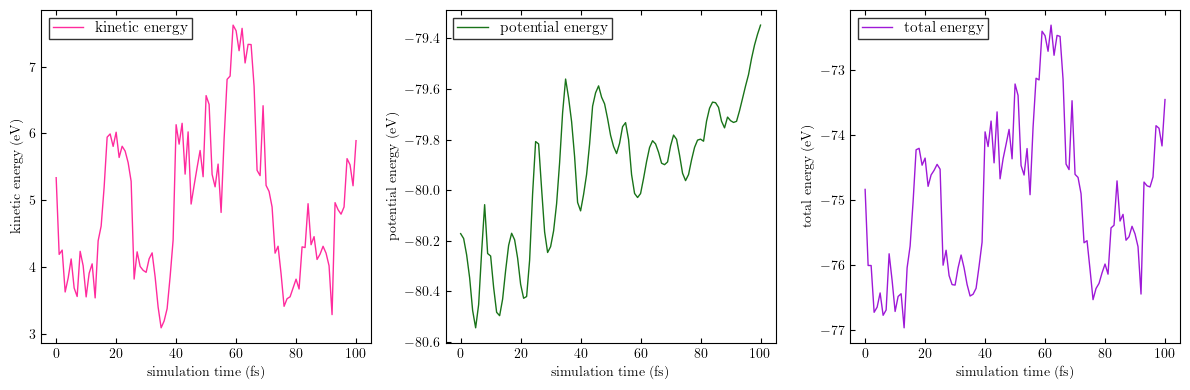

In [59]:
# PLOTS
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

# kin
ax1.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax1.plot(kinetic_energies, label=r'$\textnormal{kinetic energy}$', color='deeppink', alpha=0.9)
ax1.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{kinetic energy}\;(\textnormal{eV})$')
ax1.legend(loc='best')

# pot
ax2.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax2.plot(potential_energies, label=r'$\textnormal{potential energy}$', color='darkgreen', alpha=0.9)
ax2.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{potential energy}\;(\textnormal{eV})$')
ax2.legend(loc='best')

# total
ax3.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax3.plot(total_energies, label=r'$\textnormal{total energy}$', color='darkviolet', alpha=0.9)
ax3.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{total energy}\;(\textnormal{eV})$')
ax3.legend(loc='best')

plt.tight_layout()
plt.savefig('./Pt100_CO_MD_plots.png', dpi=300)
plt.show(fig)

### __Example 2. Melting process of Al__
Melting process of Aluminium FCC. First, an NVE MD is performed

In [ ]:
import os
from asap3 import EMT
calculator = EMT()

from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.verlet import VelocityVerlet
from ase.md import MDLogger
from ase import units
from time import perf_counter
import numpy as np

# Set up a fcc-Al crystal
atoms = bulk("Al","fcc",a=4.3,cubic=True)
atoms.pbc = True
atoms *= 3
print("atoms = ",atoms)

# Set calculator (EMT in this case)
atoms.calc = calculator

# input parameters
time_step    = 1.0      # MD step size in fsec
temperature  = 1600     # Temperature in Kelvin
num_md_steps = 100000   # Total number of MD steps
num_interval = 1000     # Print out interval for .log and .traj

# Set the momenta corresponding to the given "temperature"
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
Stationary(atoms)  # Set zero total momentum to avoid drifting

# Set output filenames
output_filename = "./liquid-Al_NVE_1.0fs_test/"
if not os.path.isdir(output_filename):
    os.makedirs(output_filename)
log_filename = output_filename + "log_file.log"
print("log_filename = ",log_filename)
traj_filename = output_filename + "trajectory.traj"
print("traj_filename = ",traj_filename)

# Remove old files if they exist
if os.path.exists(os.path.join(log_filename, '.log')): 
    os.remove(log_filename)
if os.path.exists(os.path.join(traj_filename, '.traj')): 
    os.remove(traj_filename)

# Define the MD dynamics class object
dyn = VelocityVerlet(atoms,
                     time_step * units.fs,
                     trajectory = traj_filename,
                     loginterval=num_interval
                    )

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    time_md = time_step*imd
    etot  = atoms.get_total_energy()
    ekin  = atoms.get_kinetic_energy()
    epot  = atoms.get_potential_energy()
    temp_K = atoms.get_temperature()
    print(f"   {imd: >3}     {etot:.9f}     {ekin:.9f}    {epot:.9f}   {temp_K:.2f}")

dyn.attach(print_dyn, interval=num_interval)

# Set MD logger
dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=False,peratom=False, mode="w"), interval=num_interval)

# Now run MD simulation
print(f"\n    imd     Etot(eV)    Ekin(eV)    Epot(eV)    T(K)")
dyn.run(num_md_steps)


print("\nNormal termination of the MD run!")

[Sergis-MacBook-Pro.local:65664] shmem: mmap: an error occurred while determining whether or not /var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T//ompi.Sergis-MacBook-Pro.501/jf.0/3451125760/sm_segment.Sergis-MacBook-Pro.501.cdb40000.0 could be created.


atoms =  Atoms(symbols='Al108', pbc=True, cell=[12.899999999999999, 12.899999999999999, 12.899999999999999])
log_filename =  ./liquid-Al_NVE_1.0fs_test/log_file.log
traj_filename =  ./liquid-Al_NVE_1.0fs_test/trajectory.traj

    imd     Etot(eV)    Ekin(eV)    Epot(eV)    T(K)
     0     32.139701294     22.336120234    9.803581060   1600.00
   1000     32.144573345     10.147479616    21.997093729   726.89
   2000     32.144669489     9.872400817    22.272268672   707.19
   3000     32.144653714     9.955368258    22.189285455   713.13
   4000     32.144150322     10.895194704    21.248955619   780.45
   5000     32.144105640     10.605084474    21.539021166   759.67
   6000     32.144333386     10.984207379    21.160126007   786.83
   7000     32.144442783     9.745698610    22.398744173   698.11
   8000     32.144536620     8.967299641    23.177236979   642.35
   9000     32.144551048     10.055843807    22.088707241   720.33
   10000     32.144052027     11.142429391    21.0016226

In [ ]:
# save the trajectory
from ase.io import read, write, Trajectory
from ase.visualize import view

traj = Trajectory(traj_filename)

view(traj, viewer='ngl')

In [ ]:
# analyze the trajectory 
import pandas as pd
df = pd.read_csv(log_filename, sep='\s+')
df

,Time[ps],Etot[eV],Epot[eV],Ekin[eV],T[K]
0,0.0,32.140,9.804,22.336,1600.0
1,1.0,32.145,21.997,10.147,726.9
2,2.0,32.145,22.272,9.872,707.2
3,3.0,32.145,22.189,9.955,713.1
4,4.0,32.144,21.249,10.895,780.5
...,...,...,...,...,...
96,96.0,32.144,22.396,9.749,698.3
97,97.0,32.144,21.639,10.504,752.5
98,98.0,32.144,21.863,10.281,736.5
99,99.0,32.144,21.245,10.898,780.7


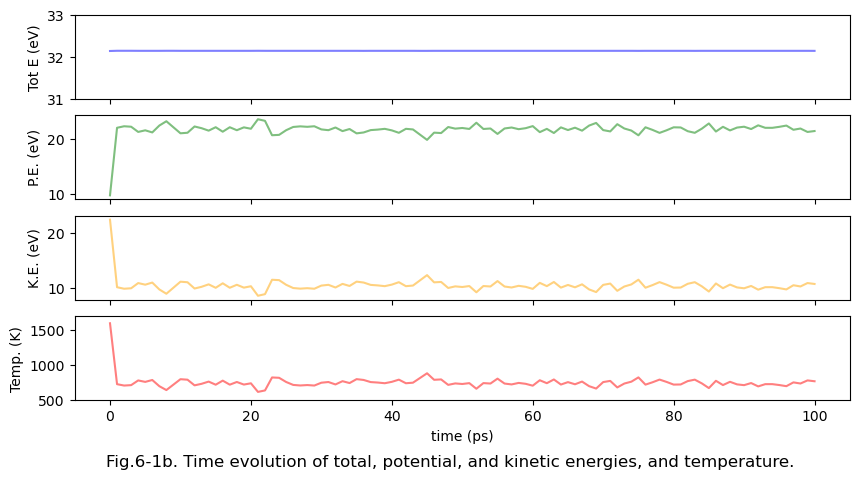

In [ ]:
# plots
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 5))

#color = 'tab:grey'
ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])
ax1.set_ylabel('Tot E (eV)')
ax1.set_ylim([31.,33.])
ax1.plot(df["Time[ps]"], df["Etot[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])
ax2.set_ylabel('P.E. (eV)')
ax2.plot(df["Time[ps]"], df["Epot[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])
ax3.set_ylabel('K.E. (eV)')
ax3.plot(df["Time[ps]"], df["Ekin[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')
ax4.set_ylabel('Temp. (K)')
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([500., 1700])

fig.suptitle("Fig.6-1b. Time evolution of total, potential, and kinetic energies, and temperature.", y=0)

#plt.savefig("6-1_liquid-Al_NVE_1.0fs_test_E_vs_t.png")  # <- Use if saving to an image file is desired
plt.show()

In [ ]:
# Additional MD NVT simulations are present in the tutorial guide. 
# https://docs.matlantis.com/atomistic-simulation-tutorial/en/6_2_md-nvt.html
# optional, show the implementation of thermostat

In [ ]:
# Additional MD NPT simulations are present in the tutorial guide. 
# https://docs.matlantis.com/atomistic-simulation-tutorial/en/6_3_md-npt.html
# optional, show the implementation of thermostat

### __Example 3. Copper NVE and NVT MD simulations__
This example requires `asap3`, only installed in `ASE_extra` venv

In [10]:
# NVE simulation 

from ase import units
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.io import Trajectory

use_asap = True
if use_asap:
    from asap3 import EMT
    size = 10
else:
    from ase.calculators.emt import EMT
    size = 3

# MD sim parameters
delta_t = 5     # fs

# define the structure, calculator and momenta
atoms = FaceCenteredCubic(directions=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                          symbol="Cu",
                          size=(size, size, size),
                          pbc=True)
atoms.calc = EMT()
MaxwellBoltzmannDistribution(atoms, temperature_K=300)




# NVE with 
dyn = VelocityVerlet(atoms, delta_t * units.fs)




# saves
kinetic_energies = []
potential_energies = []
total_energies = []

# store energies
def store_energies():
    kinetic_energy = atoms.get_kinetic_energy()
    potential_energy = atoms.get_potential_energy()
    total_energy = kinetic_energy + potential_energy
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    total_energies.append(total_energy)

# print energies (per atom)
def printenergy(a=atoms):
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print(f'E_pot\t{epot:.3f} eV\t\tE_kin\t{ekin:.3f} eV ({ekin / (1.5 * units.kB):.0f} K)\t\tE_tot\t{epot + ekin:.3f} eV')

# trajectory
traj = Trajectory('Cu_MD.traj', 'w', atoms)

# for every step, store, print the energies and save the traj
dyn.attach(store_energies, interval=10)
dyn.attach(printenergy, interval=10)
dyn.attach(traj.write, interval=10)

# 2 ps run
dyn.run(400)

E_pot	-0.001 eV		E_kin	0.038 eV (297 K)		E_tot	0.038 eV
E_pot	0.029 eV		E_kin	0.009 eV (68 K)		E_tot	0.038 eV
E_pot	0.019 eV		E_kin	0.019 eV (144 K)		E_tot	0.038 eV
E_pot	0.017 eV		E_kin	0.021 eV (159 K)		E_tot	0.038 eV
E_pot	0.017 eV		E_kin	0.021 eV (162 K)		E_tot	0.038 eV
E_pot	0.020 eV		E_kin	0.018 eV (138 K)		E_tot	0.038 eV
E_pot	0.020 eV		E_kin	0.018 eV (142 K)		E_tot	0.038 eV
E_pot	0.018 eV		E_kin	0.020 eV (154 K)		E_tot	0.038 eV
E_pot	0.018 eV		E_kin	0.020 eV (154 K)		E_tot	0.038 eV
E_pot	0.020 eV		E_kin	0.018 eV (141 K)		E_tot	0.038 eV
E_pot	0.018 eV		E_kin	0.020 eV (151 K)		E_tot	0.038 eV
E_pot	0.018 eV		E_kin	0.020 eV (152 K)		E_tot	0.038 eV
E_pot	0.019 eV		E_kin	0.019 eV (149 K)		E_tot	0.038 eV
E_pot	0.019 eV		E_kin	0.019 eV (144 K)		E_tot	0.038 eV
E_pot	0.018 eV		E_kin	0.020 eV (154 K)		E_tot	0.038 eV
E_pot	0.019 eV		E_kin	0.019 eV (148 K)		E_tot	0.038 eV
E_pot	0.019 eV		E_kin	0.019 eV (150 K)		E_tot	0.038 eV
E_pot	0.019 eV		E_kin	0.019 eV (144 K)		E_tot	0.038 eV
E_pot	0.01

True

In [11]:
from ase.visualize import view

load_traj = Trajectory('Cu_MD.traj', 'r')
view(load_traj, viewer='ngl')

In [12]:
# plot import section
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})


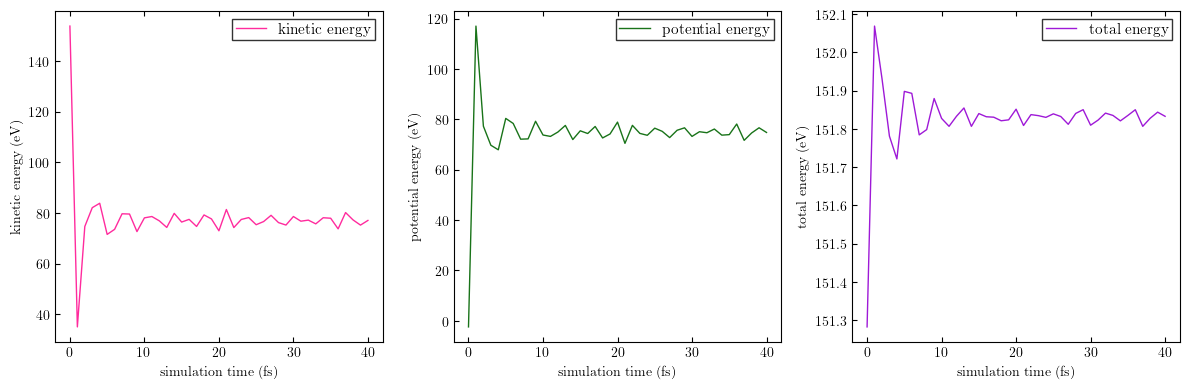

In [13]:
# PLOTS
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

# kin
ax1.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax1.plot(kinetic_energies, label=r'$\textnormal{kinetic energy}$', color='deeppink', alpha=0.9)
ax1.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{kinetic energy}\;(\textnormal{eV})$')
ax1.legend(loc='best')

# pot
ax2.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax2.plot(potential_energies, label=r'$\textnormal{potential energy}$', color='darkgreen', alpha=0.9)
ax2.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{potential energy}\;(\textnormal{eV})$')
ax2.legend(loc='best')

# total
ax3.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax3.plot(total_energies, label=r'$\textnormal{total energy}$', color='darkviolet', alpha=0.9)
ax3.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{total energy}\;(\textnormal{eV})$')
ax3.legend(loc='best')

plt.tight_layout()
plt.savefig('./Cu_MD.png', dpi=300)
plt.show(fig)

To perform an NVT calculation, we just have to change the dynamics to include a thermostat, such as Langevin `dyn = Langevin()` dynamics. 

In [16]:
# NVE simulation 

from ase import units
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.io import Trajectory

use_asap = True
if use_asap:
    from asap3 import EMT
    size = 10
else:
    from ase.calculators.emt import EMT
    size = 3

# MD sim parameters
delta_t = 5     # fs
T = 1500        # Kelvin

# define the structure, calculator and momenta
atoms = FaceCenteredCubic(directions=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                          symbol="Cu",
                          size=(size, size, size),
                          pbc=False)
atoms.calc = EMT()
dyn = Langevin(atoms, delta_t * units.fs, T * units.kB, 0.002)

# saves
kinetic_energies = []
potential_energies = []
total_energies = []

# store energies
def store_energies():
    kinetic_energy = atoms.get_kinetic_energy()
    potential_energy = atoms.get_potential_energy()
    total_energy = kinetic_energy + potential_energy
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    total_energies.append(total_energy)

# print energies (per atom)
def printenergy(a=atoms):
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print(f'E_pot\t{epot:.3f} eV\t\tE_kin\t{ekin:.3f} eV ({ekin / (1.5 * units.kB):.0f} K)\t\tE_tot\t{epot + ekin:.3f} eV')

# trajectory
traj = Trajectory('Cu_MD_NVT.traj', 'w', atoms)

# for every step, store, print the energies and save the traj
dyn.attach(store_energies, interval=100)
dyn.attach(printenergy, interval=100)
dyn.attach(traj.write, interval=100)

# 50 ps run
dyn.run(10000)

E_pot	0.135 eV		E_kin	0.000 eV (0 K)		E_tot	0.135 eV
E_pot	0.151 eV		E_kin	0.020 eV (151 K)		E_tot	0.171 eV
E_pot	0.169 eV		E_kin	0.034 eV (266 K)		E_tot	0.203 eV
E_pot	0.185 eV		E_kin	0.049 eV (376 K)		E_tot	0.234 eV
E_pot	0.199 eV		E_kin	0.062 eV (480 K)		E_tot	0.261 eV
E_pot	0.211 eV		E_kin	0.074 eV (574 K)		E_tot	0.286 eV
E_pot	0.225 eV		E_kin	0.083 eV (643 K)		E_tot	0.308 eV
E_pot	0.235 eV		E_kin	0.094 eV (727 K)		E_tot	0.329 eV
E_pot	0.250 eV		E_kin	0.100 eV (770 K)		E_tot	0.350 eV
E_pot	0.258 eV		E_kin	0.107 eV (831 K)		E_tot	0.366 eV
E_pot	0.268 eV		E_kin	0.112 eV (869 K)		E_tot	0.380 eV
E_pot	0.275 eV		E_kin	0.120 eV (926 K)		E_tot	0.395 eV
E_pot	0.286 eV		E_kin	0.124 eV (960 K)		E_tot	0.410 eV
E_pot	0.295 eV		E_kin	0.128 eV (993 K)		E_tot	0.423 eV
E_pot	0.301 eV		E_kin	0.135 eV (1048 K)		E_tot	0.437 eV
E_pot	0.311 eV		E_kin	0.138 eV (1066 K)		E_tot	0.448 eV
E_pot	0.318 eV		E_kin	0.140 eV (1085 K)		E_tot	0.459 eV
E_pot	0.327 eV		E_kin	0.140 eV (1085 K)		E_tot	0.467 eV
E_pot	0.

True

In [17]:
from ase.visualize import view

load_traj = Trajectory('Cu_MD_NVT.traj', 'r')
view(load_traj, viewer='ngl')

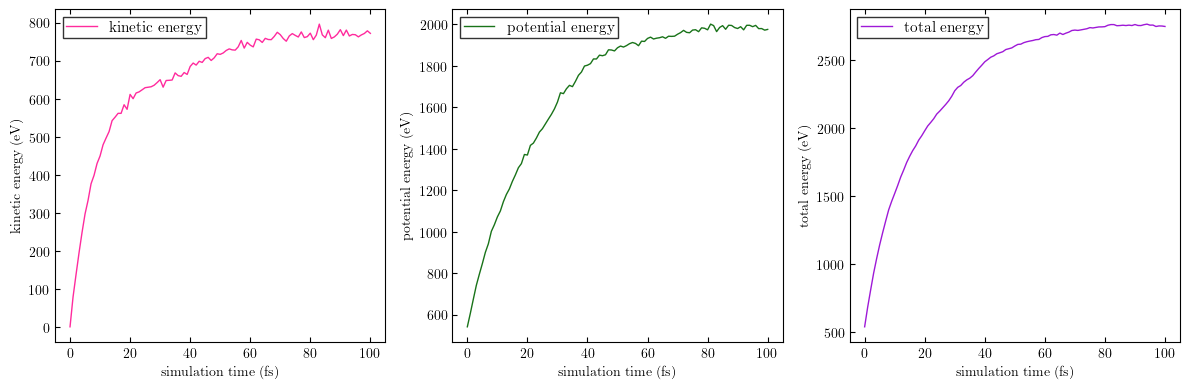

In [19]:
# PLOTS
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

# kin
ax1.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax1.plot(kinetic_energies, label=r'$\textnormal{kinetic energy}$', color='deeppink', alpha=0.9)
ax1.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{kinetic energy}\;(\textnormal{eV})$')
ax1.legend(loc='best')

# pot
ax2.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax2.plot(potential_energies, label=r'$\textnormal{potential energy}$', color='darkgreen', alpha=0.9)
ax2.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{potential energy}\;(\textnormal{eV})$')
ax2.legend(loc='best')

# total
ax3.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax3.plot(total_energies, label=r'$\textnormal{total energy}$', color='darkviolet', alpha=0.9)
ax3.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{total energy}\;(\textnormal{eV})$')
ax3.legend(loc='best')

plt.tight_layout()
plt.savefig('./Cu_MD_NVT.png', dpi=300)
plt.show(fig)

In [20]:
! ase gui Cu_MD_NVT.traj

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_extra/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_extra/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_extra/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_extra/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_extra/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_extra/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_extra/

Finally, a Cu nanoparticle MD simulation

In [28]:
# NVE simulation 

from ase import units
from ase.cluster.cubic import FaceCenteredCubic
from ase.md.velocitydistribution import (
    MaxwellBoltzmannDistribution,
    Stationary,
    ZeroRotation,
)
from ase.md.verlet import VelocityVerlet
from ase.optimize import QuasiNewton
from ase.io import Trajectory


use_asap = True
if use_asap:
    from asap3 import EMT
    size = 10
else:
    from ase.calculators.emt import EMT
    size = 3

# MD sim parameters
delta_t = 5     # fs
T = 1200        # Kelvin

# define the structure, calculator and momenta
atoms = FaceCenteredCubic('Cu',
                          surfaces=[[1, 0, 0], [1, 1, 0], [1, 1, 1]],
                          layers=(size, size, size),
                          vacuum=4)
atoms.calc = EMT()

# relaxation
opt = QuasiNewton(atoms)
opt.run(0.001, 10)


MaxwellBoltzmannDistribution(atoms, temperature_K=T)
Stationary(atoms)       # zero linear momentum
ZeroRotation(atoms)     # zero angular momentum
dyn = VelocityVerlet(atoms, delta_t * units.fs)

# saves
kinetic_energies = []
potential_energies = []
total_energies = []

# store energies
def store_energies():
    kinetic_energy = atoms.get_kinetic_energy()
    potential_energy = atoms.get_potential_energy()
    total_energy = kinetic_energy + potential_energy
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    total_energies.append(total_energy)

# print energies (per atom)
def printenergy(a=atoms):
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print(f'E_pot\t{epot:.3f} eV\t\tE_kin\t{ekin:.3f} eV ({ekin / (1.5 * units.kB):.0f} K)\t\tE_tot\t{epot + ekin:.3f} eV')

# trajectory
traj = Trajectory('Cu_nano.traj', 'w', atoms)

# for every step, store, print the energies and save the traj
dyn.attach(store_energies, interval=10)
dyn.attach(printenergy, interval=10)
dyn.attach(traj.write, interval=10)

# 10 ps run
dyn.run(2000)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 16:19:46      229.993910       0.9105
BFGSLineSearch:    1[  1] 16:19:47      227.400516       0.2107


/Users/sergiortizropero/miniconda3/envs/ASE_extra/lib/python3.10/site-packages/asap3/Internal/BuiltinPotentials.py:57: RuntimeWarning: invalid value encountered in scalar divide
  heights[i] = abs(np.dot(cell[i], direction) / np.sqrt(np.dot(direction,direction)))


BFGSLineSearch:    2[  2] 16:19:47      226.673993       0.1234
BFGSLineSearch:    3[  3] 16:19:48      226.229376       0.0818
BFGSLineSearch:    4[  4] 16:19:49      225.822527       0.0899
BFGSLineSearch:    5[  5] 16:19:51      225.465449       0.0818
BFGSLineSearch:    6[  6] 16:19:51      225.168123       0.0802
BFGSLineSearch:    7[  7] 16:19:52      224.957507       0.0629
BFGSLineSearch:    8[  8] 16:19:53      224.839176       0.0612
BFGSLineSearch:    9[  9] 16:19:54      224.799385       0.0237
BFGSLineSearch:   10[ 10] 16:19:55      224.788981       0.0140
E_pot	0.193 eV		E_kin	0.157 eV (1217 K)		E_tot	0.351 eV
E_pot	0.295 eV		E_kin	0.057 eV (438 K)		E_tot	0.351 eV
E_pot	0.279 eV		E_kin	0.073 eV (562 K)		E_tot	0.351 eV
E_pot	0.277 eV		E_kin	0.074 eV (571 K)		E_tot	0.351 eV
E_pot	0.276 eV		E_kin	0.076 eV (584 K)		E_tot	0.351 eV
E_pot	0.279 eV		E_kin	0.072 eV (558 K)		E_tot	0.351 eV
E_pot	0.278 eV		E_kin	0.073 eV (567 K)		E_tot	0.351 eV
E_pot	0.283 eV		E_kin	0.068 eV (528 K)

True

In [29]:
from ase.visualize import view

load_traj = Trajectory('Cu_nano.traj', 'r')
view(load_traj, viewer='ngl')

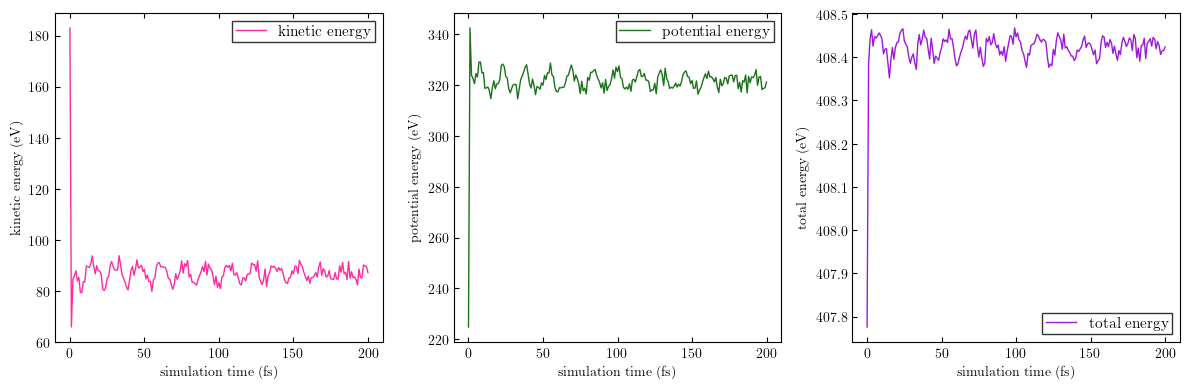

In [30]:
# PLOTS
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

# kin
ax1.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax1.plot(kinetic_energies, label=r'$\textnormal{kinetic energy}$', color='deeppink', alpha=0.9)
ax1.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{kinetic energy}\;(\textnormal{eV})$')
ax1.legend(loc='best')

# pot
ax2.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax2.plot(potential_energies, label=r'$\textnormal{potential energy}$', color='darkgreen', alpha=0.9)
ax2.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{potential energy}\;(\textnormal{eV})$')
ax2.legend(loc='best')

# total
ax3.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax3.plot(total_energies, label=r'$\textnormal{total energy}$', color='darkviolet', alpha=0.9)
ax3.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{total energy}\;(\textnormal{eV})$')
ax3.legend(loc='best')

plt.tight_layout()
plt.savefig('./Cu_nano.png', dpi=300)
plt.show(fig)

### __Example 4. Equilibration of a solvent box__
Another NVT example of equilibrating a box of TIP3P waters (rigid molecules). The TIP3P force field is contained in `ase.calculators.tip3p`. Remember that when changing the system, if a different interatomic potential wants to be used, a different calculator is necessary!

In [ ]:
import numpy as np

import ase.units as units
from ase import Atoms
from ase.calculators.tip3p import TIP3P, angleHOH, rOH
from ase.constraints import FixBondLengths
from ase.io.trajectory import Trajectory
from ase.md import Langevin
from ase.optimize import QuasiNewton

# Set up water box at 20 deg C density
x = angleHOH * np.pi / 180 / 2
pos = [[0, 0, 0],
       [0, rOH * np.cos(x), rOH * np.sin(x)],
       [0, rOH * np.cos(x), -rOH * np.sin(x)]]
atoms = Atoms('OH2', positions=pos)

vol = ((18.01528 / 6.022140857e23) / (0.9982 / 1e24))**(1 / 3.)
atoms.set_cell((vol, vol, vol))
atoms.center()
atoms = atoms.repeat((3, 3, 3))
atoms.rattle(stdev=0.2, rng=np.random.RandomState())
atoms.set_pbc(True)

# RATTLE-type constraints on O-H1, O-H2, H1-H2.
atoms.constraints = FixBondLengths([(3 * i + j, 3 * i + (j + 1) % 3)
                                    for i in range(3**3)
                                    for j in [0, 1, 2]])

tag = 'something'
atoms.calc = TIP3P(rc=4.5)
dyn = Langevin(atoms, 1 * units.fs, temperature_K=300 * units.kB,
              friction=0.01, logfile=tag + '.log')

# saves
kinetic_energies = []
potential_energies = []
total_energies = []

# store energies
def store_energies():
    kinetic_energy = atoms.get_kinetic_energy()
    potential_energy = atoms.get_potential_energy()
    total_energy = kinetic_energy + potential_energy
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    total_energies.append(total_energy)

# print energies (per atom)
def printenergy(a=atoms):
    epot = a.get_potential_energy() 
    ekin = a.get_kinetic_energy()
    print(f'E_pot\t{epot:.3f} eV\t\tE_kin\t{ekin:.3f} eV ({ekin / (1.5 * units.kB):.0f} K)\t\tE_tot\t{epot + ekin:.3f} eV')

# trajectory
traj = Trajectory(tag + '.traj', 'w', atoms)

# for every step, store, print the energies and save the traj
dyn.attach(store_energies, interval=10)
dyn.attach(printenergy, interval=10)
dyn.attach(traj.write, interval=10)
dyn.run(400)

E_pot	10.941 eV		E_kin	0.000 eV (0 K)		E_tot	10.941 eV
E_pot	3.715 eV		E_kin	7.159 eV (55387 K)		E_tot	10.874 eV
E_pot	-6.062 eV		E_kin	16.677 eV (129022 K)		E_tot	10.616 eV
E_pot	-7.721 eV		E_kin	17.985 eV (139138 K)		E_tot	10.264 eV
E_pot	-7.021 eV		E_kin	16.934 eV (131007 K)		E_tot	9.913 eV
E_pot	-8.192 eV		E_kin	17.775 eV (137513 K)		E_tot	9.583 eV
E_pot	-7.623 eV		E_kin	16.847 eV (130331 K)		E_tot	9.224 eV
E_pot	-8.267 eV		E_kin	16.855 eV (130399 K)		E_tot	8.588 eV
E_pot	-7.443 eV		E_kin	15.755 eV (121886 K)		E_tot	8.312 eV
E_pot	-8.007 eV		E_kin	15.975 eV (123590 K)		E_tot	7.968 eV
E_pot	-9.249 eV		E_kin	16.892 eV (130679 K)		E_tot	7.642 eV
E_pot	-9.415 eV		E_kin	16.734 eV (129458 K)		E_tot	7.318 eV
E_pot	-9.463 eV		E_kin	16.472 eV (127433 K)		E_tot	7.009 eV
E_pot	-9.970 eV		E_kin	16.669 eV (128958 K)		E_tot	6.699 eV
E_pot	-8.934 eV		E_kin	15.275 eV (118176 K)		E_tot	6.341 eV
E_pot	-8.928 eV		E_kin	14.971 eV (115820 K)		E_tot	6.043 eV
E_pot	-10.256 eV		E_kin	15.994 eV (123736 K)	

True

In [ ]:
from ase.visualize import view

load_traj = Trajectory(tag + '.traj', 'r')
view(load_traj, viewer='ngl')

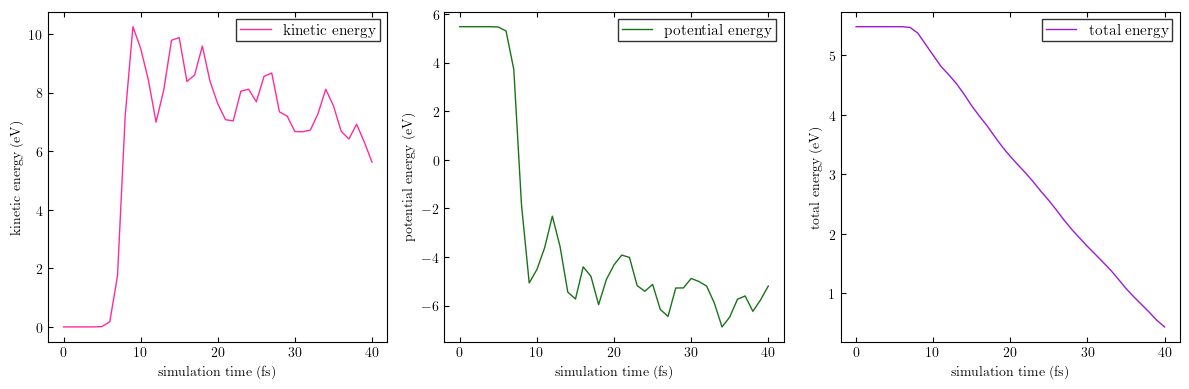

In [35]:
# PLOTS
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

# kin
ax1.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax1.plot(kinetic_energies, label=r'$\textnormal{kinetic energy}$', color='deeppink', alpha=0.9)
ax1.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{kinetic energy}\;(\textnormal{eV})$')
ax1.legend(loc='best')

# pot
ax2.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax2.plot(potential_energies, label=r'$\textnormal{potential energy}$', color='darkgreen', alpha=0.9)
ax2.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{potential energy}\;(\textnormal{eV})$')
ax2.legend(loc='best')

# total
ax3.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax3.plot(total_energies, label=r'$\textnormal{total energy}$', color='darkviolet', alpha=0.9)
ax3.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{total energy}\;(\textnormal{eV})$')
ax3.legend(loc='best')

plt.tight_layout()
plt.savefig('./TIP3P_Waters.png', dpi=300)
plt.show(fig)

In [5]:
# Repeat box and equilibrate further.
tag = 'tip3p_216mol_equil'
atoms.set_constraint()  # repeat not compatible with FixBondLengths currently.
atoms = atoms.repeat((2, 2, 2))
atoms.constraints = FixBondLengths([(3 * i + j, 3 * i + (j + 1) % 3)
                                    for i in range(int(len(atoms) / 3))
                                    for j in [0, 1, 2]])
atoms.calc = TIP3P(rc=7.)
md = Langevin(atoms, 2 * units.fs, temperature_K=300 * units.kB,
              friction=0.01, logfile=tag + '.log')

traj = Trajectory(tag + '.traj', 'w', atoms)
md.attach(traj.write, interval=1)
md.run(200)

RuntimeError: Did not converge

In [ ]:
from ase.visualize import view

load_traj = Trajectory(tag + '.traj', 'r')
view(load_traj, viewer='ngl')

If, instead of TIP3P waters, acetonytrile is to be used as solvent (NVT), `ase.calculators.acn` provides a suitable forcefield (ACN is considered to be neutral). Any other solvent can be used, but a suitable FF must be present within ASE. 

In [75]:
import numpy as np

import ase.units as units
from ase import Atoms
from ase.calculators.acn import ACN, m_me, r_cn, r_mec
from ase.constraints import FixLinearTriatomic
from ase.io import Trajectory
from ase.md import Langevin
from ase.optimize import QuasiNewton

pos = [[0, 0, -r_mec],
       [0, 0, 0],
       [0, 0, r_cn]]
atoms = Atoms('CCN', positions=pos)
atoms.rotate(30, 'x')

# First C of each molecule needs to have the mass of a methyl group
masses = atoms.get_masses()
masses[::3] = m_me
atoms.set_masses(masses)

# Determine side length of a box with the density of acetonitrile at 298 K
# Density in g/Ang3 (https://pubs.acs.org/doi/10.1021/je00001a006)
d = 0.776 / 1e24
L = ((masses.sum() / units.mol) / d)**(1 / 3.)
# Set up box of 27 acetonitrile molecules
atoms.set_cell((L, L, L))
atoms.center()
atoms = atoms.repeat((3, 3, 3))
atoms.rattle(stdev=0.2, rng=np.random.RandomState())
atoms.set_pbc(True)



# Set constraints for rigid triatomic molecules
nm = 27
atoms.constraints = FixLinearTriatomic(
    triples=[(3 * i, 3 * i + 1, 3 * i + 2)
             for i in range(nm)])

tag = 'acn_27mol_300K'
atoms.calc = ACN(rc=np.min(np.diag(atoms.cell)) / 2)

# relaxation
opt = QuasiNewton(atoms)
opt.run(0.001, 10)

# Create Langevin object
dyn = Langevin(atoms, 1 * units.fs,
              temperature_K=300 * units.kB,
              friction=0.01,
              logfile=tag + '.log')


# saves
kinetic_energies = []
potential_energies = []
total_energies = []

# store energies
def store_energies():
    kinetic_energy = atoms.get_kinetic_energy()
    potential_energy = atoms.get_potential_energy()
    total_energy = kinetic_energy + potential_energy
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    total_energies.append(total_energy)

# print energies (per atom)
def printenergy(a=atoms):
    epot = a.get_potential_energy() 
    ekin = a.get_kinetic_energy()
    print(f'E_pot\t{epot:.3f} eV\t\tE_kin\t{ekin:.3f} eV ({ekin / (1.5 * units.kB):.0f} K)\t\tE_tot\t{epot + ekin:.3f} eV')

# trajectory
traj = Trajectory(tag + '.traj', 'w', atoms)

# for every step, store, print the energies and save the traj
dyn.attach(store_energies, interval=100)
dyn.attach(printenergy, interval=100)
dyn.attach(traj.write, interval=100)

# 4 ps
dyn.run(4000)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 17:07:09       48.942002      57.5093
BFGSLineSearch:    1[  1] 17:07:09       33.424561      14.3630
BFGSLineSearch:    2[  3] 17:07:09       17.338893      11.1669
BFGSLineSearch:    3[  5] 17:07:10       11.272053      12.9418
BFGSLineSearch:    4[  6] 17:07:10        7.780578       6.3074
BFGSLineSearch:    5[  7] 17:07:10        4.797677       4.4554
BFGSLineSearch:    6[  8] 17:07:10        2.494233       2.5893
BFGSLineSearch:    7[  9] 17:07:10        1.739897       1.4107
BFGSLineSearch:    8[ 10] 17:07:10        1.424259       0.7439
BFGSLineSearch:    9[ 12] 17:07:10        1.134071       0.7444
BFGSLineSearch:   10[ 17] 17:07:10        0.474741       0.4212
E_pot	0.475 eV		E_kin	0.000 eV (0 K)		E_tot	0.475 eV
E_pot	-1.633 eV		E_kin	1.960 eV (15160 K)		E_tot	0.327 eV
E_pot	-2.770 eV		E_kin	2.592 eV (20056 K)		E_tot	-0.178 eV
E_pot	-3.175 eV		E_kin	2.462 eV (19047 K)		E_tot	-0.713 eV
E_

True

In [76]:
from ase.visualize import view

load_traj = Trajectory(tag + '.traj', 'r')
view(load_traj, viewer='ngl')

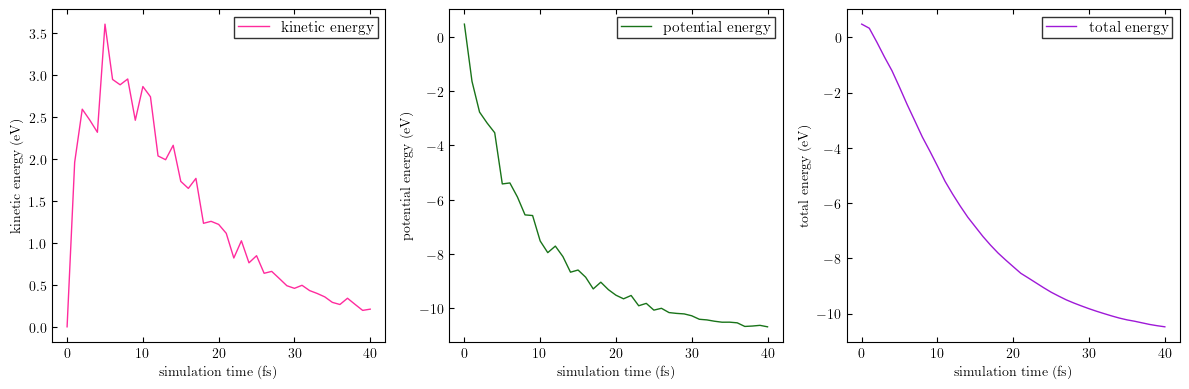

In [77]:
# PLOTS
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

# kin
ax1.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax1.plot(kinetic_energies, label=r'$\textnormal{kinetic energy}$', color='deeppink', alpha=0.9)
ax1.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{kinetic energy}\;(\textnormal{eV})$')
ax1.legend(loc='best')

# pot
ax2.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax2.plot(potential_energies, label=r'$\textnormal{potential energy}$', color='darkgreen', alpha=0.9)
ax2.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{potential energy}\;(\textnormal{eV})$')
ax2.legend(loc='best')

# total
ax3.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax3.plot(total_energies, label=r'$\textnormal{total energy}$', color='darkviolet', alpha=0.9)
ax3.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{total energy}\;(\textnormal{eV})$')
ax3.legend(loc='best')

plt.tight_layout()
plt.savefig('./ACN_MD.png', dpi=300)
plt.show(fig)

And finally the production run

In [78]:
# Repeat box and equilibrate further
atoms.set_constraint()
atoms = atoms.repeat((2, 2, 2))
nm = 216
atoms.constraints = FixLinearTriatomic(
    triples=[(3 * i, 3 * i + 1, 3 * i + 2)
             for i in range(nm)])

tag = 'acn_216mol_300K'
atoms.calc = ACN(rc=np.min(np.diag(atoms.cell)) / 2)

# Create Langevin object
md = Langevin(atoms, 2 * units.fs,
              temperature=300 * units.kB,
              friction=0.01,
              logfile=tag + '.log')

traj = Trajectory(tag + '.traj', 'w', atoms)
md.attach(traj.write, interval=1)
md.attach(printenergy, interval=100)

# 1 ps run
md.run(500)

E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K)		E_tot	-10.481 eV
E_pot	-10.691 eV		E_kin	0.210 eV (1627 K

True

In [79]:
load_traj = Trajectory('acn_216mol_300K.traj', 'r')
view(load_traj, viewer='ngl')